<a href="https://colab.research.google.com/github/Antonela89/Challenge_Robot_Trading_1/blob/main/Challenge_Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 - Configuración del ambiente



In [1]:
#corroboración de versiones de librerias necesarias
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.23.5
------
Name: matplotlib
Version: 3.7.1


In [2]:
#importación de librerias necesarias
#importacion de yfinance (Api de finanzas)
import yfinance as yf
import pandas as pd

#web scraping
from bs4 import BeautifulSoup
import requests

#graficos
%matplotlib inline
import matplotlib.pyplot as plt

#temporizador
from IPython.display import clear_output
import time

In [3]:
#definicion de variables globales:
global df_bitcoin
global precio_actual
global tendencia
global media_bitcoin
global algoritmo_decision

#2 - Obtención de datos

In [4]:
def importar_base_bitcoin():

  global df_bitcoin

  bitcoin = yf.Ticker('BTC-USD')
  df_bitcoin = bitcoin.history(period='7d', interval='5m')

  return df_bitcoin

In [5]:
def extraer_tendencias():

  global precio_actual
  global tendencia
  global media_bitcoin

  headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/118.0'} #cabeceras segun dispositivo
  url = 'https://coinmarketcap.com'

  respuesta = requests.get(url, headers = headers)
  s = BeautifulSoup(respuesta.content, features='lxml')

  precio = s.find('a',{'href':'/currencies/bitcoin/#markets'})

  precio_actual = precio.text
  precio_actual = precio_actual.replace(',','')
  precio_actual = float(precio_actual.replace('$',''))

  tendencia = s.find('span',{'class':'sc-d55c02b-0'})
  tendencia_color = tendencia['class'][1]

  tendencia_icono = tendencia.span['class']
  #baja: icon-Caret-down => negativo
  #alta: icon-Caret-up => positivo

  if (tendencia_color == 'gUnzUB' and  tendencia_icono == ['icon-Caret-down']):
    tendencia = 'baja'
  elif (tendencia_color == 'iwhBxy' and tendencia_icono == ['icon-Caret-up']):
    tendencia = 'alta'

  return precio_actual, tendencia

#3 - Limpieza de datos

In [10]:
def limpieza_datos():

  global media_bitcoin

  df_bitcoin_limpio = importar_base_bitcoin()
  #df_bitcoin_limpio.info()

  df_bitcoin_limpio.drop_duplicates(inplace=True)
  df_bitcoin_limpio = df_bitcoin_limpio.dropna(subset=['Close'])
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] != 0]

  #df_bitcoin_limpio.info()

  #fig, axs = plt.subplots(2, 1, figsize=(8, 10))  # Create a 2-row, 1-column subplot

  #grafico 1
  #axs[0].boxplot(df_bitcoin_limpio['Close'])
  #axs[0].set_title('Boxplot antes de la limpieza')
  #axs[0].set_ylabel('Valores al cierre')

  precio_cierre = df_bitcoin_limpio['Close']
  Q1 = precio_cierre.quantile(0.25)  # Primer cuartil
  Q3 = precio_cierre.quantile(0.75)  # Tercer cuartil
  IQR = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR

  seleccion = ((precio_cierre >= Q1) & (precio_cierre <= Q3))
  df_nuevo = df_bitcoin_limpio[seleccion]

  #grafico 2
  #axs[1].boxplot(df_nuevo['Close'])
  #axs[1].set_title('Boxplot después de la limpieza')
  #axs[1].set_ylabel('Valores al cierre')

  #plt.tight_layout()  #Ajustar el diseño de la trama secundaria
  #plt.show()  #muestra los graficos

  media_bitcoin = (df_nuevo['Close'].mean()).round(2)

  return media_bitcoin

#4 - Tomar Decisiones

In [11]:
def tomar_decisiones():

  global precio_actual
  global media_bitcoin
  global tendencia
  global algoritmo_decision

  if precio_actual <= media_bitcoin and tendencia == 'alta':
    algoritmo_decision = 'Comprar'
  elif precio_actual >= media_bitcoin and tendencia == 'baja':
    algoritmo_decision = 'Vender'
  else:
    algoritmo_decision = 'Esperar'

  return algoritmo_decision

#5 - Visualización

In [12]:
def visualizacion():

  global df_bitcoin
  global media_bitcoin

  df_bitcoin['Promedio'] = media_bitcoin
  plt.rc('figure', figsize = (16,5));
  plt.subplot();
  plt.title('Variación de precio de cierre de Bitcoin durante 7 días');
  plt.xlabel('Fechas')
  plt.ylabel('Precios')
  plt.plot(df_bitcoin.index,df_bitcoin.Close, label = 'Precio cierre Bitcoin');
  plt.plot(df_bitcoin.index,df_bitcoin.Promedio, label = 'Promedio');
  decision = tomar_decisiones()
  plt.annotate(f'Decisión: {decision}', xy=(df_bitcoin.index[0], df_bitcoin.Close[0]), xytext=(df_bitcoin.index[0], df_bitcoin.Close[-1]));
  plt.legend(loc='best')

  plt.show();

#6 - Automatización

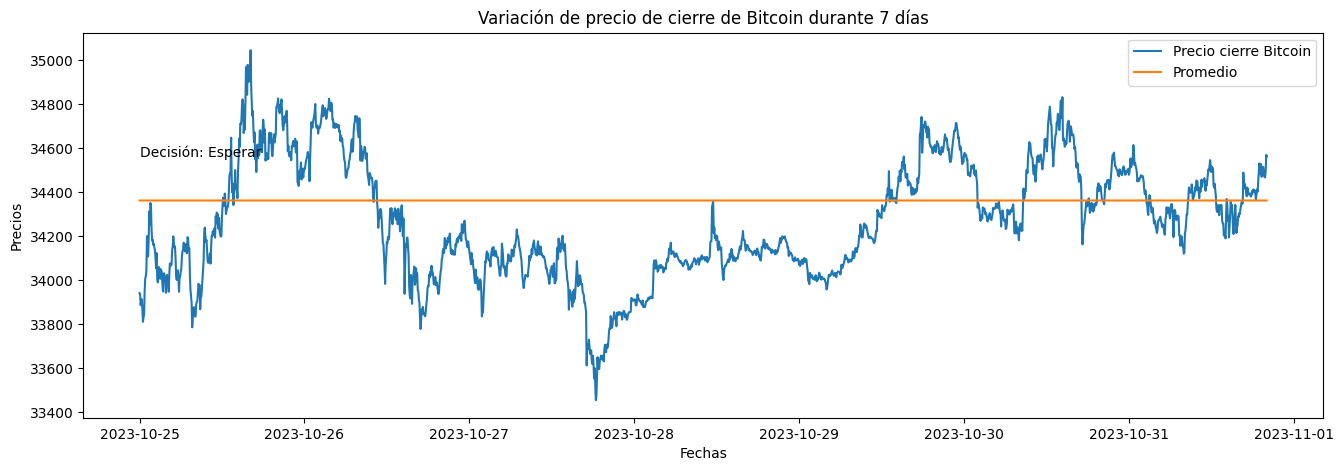

In [ ]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300) #intervalo de 5 minutos para la toma de decisiones